# pPXF: Tied gas emission lines and stellar population

![pPXF](https://www-astro.physics.ox.ac.uk/~cappellari/software/ppxf_logo.svg)

## Description

Usage example for the procedure pPXF originally described in 
[Cappellari & Emsellem (2004)](http://adsabs.harvard.edu/abs/2004PASP..116..138C),
substantially upgraded in 
[Cappellari (2017)](http://adsabs.harvard.edu/abs/2017MNRAS.466..798C) 
and with the inclusion of photometry and linear constraints in 
[Cappellari (2023)](https://ui.adsabs.harvard.edu/abs/2023MNRAS.526.3273C).

This example shows how to tie the kinematics of gas emission lines to study
stellar population and gas emission lines.

### MODIFICATION HISTORY

 - V1.0.0: Adapted from `ppxf_kinematic_example`.
      Michele Cappellari, Oxford, 12 October 2011
 - V1.1.0: Made a separate routine for the construction of the templates
      spectral library. MC, Vicenza, 11 October 2012
 - V1.1.1: Includes `regul_error` definition. MC, Oxford, 15 November 2012
 - V2.0.0: Translated from IDL into Python. MC, Oxford, 6 December 2013
 - V2.0.1: Fit SDSS rather than SAURON spectrum. MC, Oxford, 11 December 2013
 - V2.1.0: Includes gas emission as templates instead of masking the spectrum.
      MC, Oxford, 7 January 2014
 - V2.1.1: Support both Python 2.6/2.7 and Python 3.x. MC, Oxford, 25 May 2014
 - V2.1.2: Illustrates how to print and plot emission lines.
      MC, Oxford, 5 August 2014
 - V2.1.3: Only includes emission lines falling within the fitted wavelength
      range. MC, Oxford, 3 September 2014
 - V2.1.4: Explicitly sort template files as `glob()` output may not be sorted.
      Thanks to Marina Trevisan for reporting problems under Linux.
      MC, Sydney, 4 February 2015
 - V2.1.5: Included `origin='upper'` in `imshow()`. Thanks to Richard McDermid
      for reporting a different default value with older Matplotlib versions.
      MC, Oxford, 17 February 2015
 - V2.1.6: Use `color=` instead of `c=` to avoid new Matplotlib bug.
      MC, Oxford, 25 February 2015
 - V2.1.7: Uses Pyfits from Astropy to read FITS files.
      MC, Oxford, 22 October 2015
 - V2.1.8: Included treatment of the SDSS/MILES vacuum/air wavelength difference.
      MC, Oxford, 12 August 2016
 - V2.1.9: Automate and test computation of nAge and nMetals.
      MC, Oxford 1 November 2016
 - V3.0.0: Major upgrade. Compute mass-weighted population parameters and M/L
      using the new `miles` class which leaves no room for user mistakes.
      MC, Oxford, 2 December 2016
 - V3.0.1: Make files paths relative to this file, to run the example from
      any directory. MC, Oxford, 18 January 2017
 - V3.1.1: Use `ppxf` method `pp.plot(gas_component=...)` to produce gas
      emission lines plot. MC, Oxford, 13 March 2017
 - V3.2.0: Illustrates how to tie gas emission lines for MaNGA DAP MPL-6.
      MC, Oxford, 2 June 2017
 - V3.3.0: Adapted to work with ppxf package v8.2.
      Included both `tied` and `constr_kinem`.
      MC, Oxford, 10 October 2022
 - V3.4.0: Use the new `sps_util` instead of `miles_util`. 
      MC, Oxford, 12 November 2023
 - V3.5.0: Included XSL SPS models. MC, Oxford. 29 may 2024

___

In [1]:
from time import perf_counter as clock
from pathlib import Path
from urllib import request

import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

from ppxf.ppxf import ppxf
import ppxf.ppxf_util as util
import ppxf.sps_util as lib

Read SDSS galaxy spectrum taken from here https://www.sdss4.org/.
The spectrum is *already* log rebinned by the SDSS
pipeline and `log_rebin` should not be used in this case.

In [2]:
ppxf_dir = Path(lib.__file__).parent
file = ppxf_dir / 'spectra' / 'NGC3073_SDSS_DR18.fits'
hdu = fits.open(file)
t = hdu['COADD'].data
redshift = hdu['SPECOBJ'].data['z'].item()       # SDSS redshift estimate

galaxy = t['flux']/np.median(t['flux'])   # Normalize spectrum to avoid numerical issues
ln_lam_gal = t['loglam']*np.log(10)       # Convert lg --> ln
lam_gal = np.exp(ln_lam_gal)              # Wavelength in Angstroms (log sampled)

The SDSS wavelengths are in vacuum, while the MILES ones are in air.
For a rigorous treatment, the SDSS vacuum wavelengths should be
converted into air wavelengths and the spectra should be resampled.
To avoid resampling, given that the wavelength dependence of the
correction is very weak, I approximate it with a constant factor.

In [3]:
lam_gal *= np.median(util.vac_to_air(lam_gal)/lam_gal)

The noise level is chosen to give `Chi^2/DOF=1` without regularization (`regul=0`).
A constant noise is not a bad approximation in the fitted wavelength
range and reduces the noise in the fit.

In [4]:
noise = np.full_like(galaxy, 0.01635)           # Assume constant noise per pixel here

The velocity step was already chosen by the SDSS pipeline,
and we convert it below to km/s

In [5]:
c = 299792.458 # speed of light in km/s
d_ln_lam_gal = (ln_lam_gal[-1] - ln_lam_gal[0])/(ln_lam_gal.size - 1)  # Use full lam range for accuracy
velscale = c*d_ln_lam_gal                   # Velocity scale in km/s per pixel (eq.8 of Cappellari 2017)

I convert the instrumental dispersion to Angstroms

In [6]:
dlam_gal = np.gradient(lam_gal)             # Size of every pixel in Angstroms
wdisp = t['wdisp']                          # Instrumental dispersion of every pixel, in pixels units
fwhm_gal = 2.355*wdisp*dlam_gal             # Resolution FWHM of every pixel, in Angstroms

## Setup stellar templates 

pPXF can be used with any set of SPS population templates. However, I am
currently providing (with permission) ready-to-use template files for four
SPS. One can just uncomment one of the four models below. The included files
are only a subset of the SPS that can be produced with the models, and one
should use the relevant software/website to produce different sets of SPS
templates if needed.

1. If you use the [fsps v3.2](https://github.com/cconroy20/fsps) SPS model
   templates, please also cite in your paper 
   [Conroy et al. (2009)](https://ui.adsabs.harvard.edu/abs/2009ApJ...699..486C) and
   [Conroy et al. (2010)](https://ui.adsabs.harvard.edu/abs/2010ApJ...712..833C).

2. If you use the [GALAXEV v2020](http://www.bruzual.org/bc03/) SPS model 
   templates, please also cite in your paper 
   [Bruzual & Charlot (2003)](https://ui.adsabs.harvard.edu/abs/2003MNRAS.344.1000B).

3. If you use the [E-MILES](http://miles.iac.es/) SPS model templates,
   please also cite  in your paper 
   [Vazdekis et al. (2016)](https://ui.adsabs.harvard.edu/abs/2016MNRAS.463.3409V).
   <font color="red">WARNING: The E-MILES models only include SPS with age > 63 Myr and
   are not recommended for highly star forming galaxies.</font>

4. If you use the [X-Shooter Spectral Library (XSL)](http://xsl.u-strasbg.fr/) 
   SPS model templates, please also cite in your paper 
   [Verro et al. (2022)](https://ui.adsabs.harvard.edu/abs/2022A%26A...661A..50V). 
   <font color="red">WARNING: The XSL models only include SPS with age > 50 Myr and
   are not recommended for highly star forming galaxies.</font>

In [7]:
# sps_name = 'fsps'
# sps_name = 'galaxev'
sps_name = 'emiles'
# sps_name = 'xsl'

Read SPS models file from my GitHub if not already in the ppxf package dir.
The SPS model files are also available on my [GitHub Page](https://github.com/micappe/ppxf_data).

In [8]:
basename = f"spectra_{sps_name}_9.0.npz"
filename = ppxf_dir / 'sps_models' / basename
if not filename.is_file():
    url = "https://raw.githubusercontent.com/micappe/ppxf_data/main/" + basename
    request.urlretrieve(url, filename)

fwhm_gal_dic = {"lam": lam_gal, "fwhm": fwhm_gal}
sps = lib.sps_lib(filename, velscale, fwhm_gal_dic)

stars_templates = sps.templates.reshape(sps.templates.shape[0], -1)

Construct a set of Gaussian emission line templates.
Estimate the wavelength fitted range in the rest frame.

In [9]:
lam_range_gal = np.array([np.min(lam_gal), np.max(lam_gal)])/(1 + redshift)
gas_templates, gas_names, gas_wave = \
    util.emission_lines(sps.ln_lam_temp, lam_range_gal, fwhm_gal_dic)

Emission lines included in gas templates:
['H10' 'H9' 'H8' 'Heps' 'Hdelta' 'Hgamma' 'Hbeta' 'Halpha' '[SII]6716'
 '[SII]6731' '[NeIII]3968' '[NeIII]3869' 'HeII4687' 'HeI5876'
 '[OIII]5007_d' '[OI]6300_d' '[NII]6583_d']


Combines the stellar and gaseous templates into a single array
during the PPXF fit, they will be assigned a different kinematic
`component` value

In [10]:
templates = np.column_stack([stars_templates, gas_templates])

n_temps = stars_templates.shape[1]

## pPXF fit 

The important formula below **defines** the relation between velocity,
wavelength and redshift in ``pPXF`` (eq. 8 of 
[Cappellari 2017](https://ui.adsabs.harvard.edu/abs/2017MNRAS.466..798C))
I use it below to get an estimate of the stellar kinematics [V, sigma] starting
from an approximate galaxy redshift.

$$V\equiv c\Delta\ln\lambda = c\ln(1+z)$$

In [11]:
vel0 = c*np.log(1 + redshift)
sol = [vel0, 200]

- All stellar templates are in the same `component=0`. 
- The Balmer lines share the same LOSVD and are assigned the same kinematic `component=1`. 
- The other lines are assigned to their own `component=2--8`. 
- Both lines of doublets with fixed 1/3 ratio are in the same kinematic `component=6--8`.

This is the full list of components: 

0. component: Stellar kinematics
1. component: 'H10' 'H9' 'H8' 'Heps' 'Hdelta' 'Hgamma' 'Hbeta' 'Halpha'
2. component: '[SII]6716' '[SII]6731'
3. component: '[NeIII]3968' '[NeIII]3869'
4. component: 'HeII4687'
5. component: 'HeI5876'
6. component: '[OIII]5007_d'
7. component: '[OI]6300_d'
8. component: '[NII]6583_d'


In [12]:
component = [0]*n_temps  # Single stellar kinematic component=0 for all templates
component += [1]*8
component += [2, 2, 3, 3, 4, 5, 6, 7, 8]
component = np.array(component)

Fit two `moments=2` (V, sigma) for all 9 kinematic components.

In [13]:
moments = [2]*9

The next command produces a list of `start` starting guesses, one for each component:

0. [V0, sig0] stellar kinematics
1. [V1, sig1] Balmer lines kinematics
2. [V2, sig2] '[SII]6716' '[SII]6731'
3. [V3, sig3] '[NeIII]3968' '[NeIII]3869'
4. [V4, sig4] 'HeII4687'
5. [V5, sig5] 'HeI5876'
6. [V6, sig6] '[OIII]5007_d'
7. [V7, sig7] '[OI]6300_d'
8. [V8, sig8] '[NII]6583_d'

In [14]:
start = [sol for j in range(len(moments))]  # adopt the same starting value for both gas and stars

Set the *equality* constraint that V of all `components 3--8` is equal to V2,
which is parameter no.4 (`p[0]=V0, p[1]=sig0, p[2]=V1, p[3]=sig1, p[4]=V2`).
This implies that the final pPXF solution will be a list:

0. [V0, sig0]  stellar kinematics
1. [V1, sig1]  Balmer lines kinematics
2. [V2, sig2]  '[SII]6716' '[SII]6731'
3. [V2, sig3]  '[NeIII]3968' '[NeIII]3869'
4. [V2, sig4]  'HeII4687'
5. [V2, sig5]  'HeI5876'
6. [V2, sig6]  '[OIII]5007_d'
7. [V2, sig7]  '[OI]6300_d'
8. [V2, sig8]  '[NII]6583_d'

In [15]:
tied = [['', ''] for j in range(len(moments))]
for j in range(3, len(moments)):
    tied[j][0] = 'p[4]'

In addition, I set the *inequality* constrain that the sigma of the gas lines
must be smaller than 2x the stellar sigma. This is to prevent nearly-undetected
gas lines, which are unconstrained by the data, to become unrealistically broad
and mimic the effect of a smooth stellar continuum. For this, I set the
constraint that the velocity dispersion of the gas `component=1--8` must be
less than twice the sigma of the stars `component=0`. In formulas, I want to
have:

$$
\begin{cases}
  \sigma_1 < 2\sigma_0\\
  \sigma_2 < 2\sigma_0\\
  \vdots\\
  \sigma_8 < 2\sigma_0
\end{cases}
$$

Following standard practice in numerical optimization (e.g.
[HERE](https://uk.mathworks.com/help/optim/ug/linear-constraints.html)), I
express these two inequalities as linear constraints in matrix form as this
leads to an efficient optimization algorithm, with guaranteed local
convergence:

$$\mathbf{A}_{\rm ineq}\cdot \mathbf{p} < \mathbf{b}_{\rm ineq}.$$

In this example, the vector of nonlinear kinematic parameters is
$\mathbf{p}=[V_0, \sigma_0, V_1, \sigma_1, \ldots V_8, \sigma_8]$
(following the same order of the `start` parameter of `pPXF`) and I can write
the above matrix equation explicitly as

$$
\begin{bmatrix}
  0 & -2 & 0 & 1 & 0 & 0 & 0 & 0 & \ldots & 0\\
  0 & -2 & 0 & 0 & 0 & 1 & 0 & 0 &  & 0\\
  0 & -2 & 0 & 0 & 0 & 0 & 0 & 1 &  & 0\\
  \vdots &  &  &  &  &  &  &  &  \ddots & \vdots \\
  0 & -2 & 0 & 0 & 0 & 0 & 0 & 0 & \ldots & 1\\
\end{bmatrix}
\cdot
\begin{bmatrix}
  V_0 \\
  \sigma_0 \\
  V_1 \\
  \sigma_1\\
  \vdots \\
  V_8 \\
  \sigma_8
\end{bmatrix}
<
\begin{bmatrix}
  0 \\
  0 \\
  \vdots\\
  0 \\
\end{bmatrix}.
$$

This translates into the following Python code

In [16]:
#          V0 s0 V1 s1 V2 s2 V3 s3 V4 s4 V5 s5 V6 s6 V7 s7 V8 s8
A_ineq = [[0, -2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # -2*s0 + s1 < 0 => s1 < 2*s0
          [0, -2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # s2 < 2*s0
          [0, -2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # s3 < 2*s0
          [0, -2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],  # s4 < 2*s0
          [0, -2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],  # s5 < 2*s0
          [0, -2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],  # s6 < 2*s0
          [0, -2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],  # s7 < 2*s0
          [0, -2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]]  # s8 < 2*s0
b_ineq = [0, 0, 0, 0, 0, 0, 0, 0]
constr_kinem = {"A_ineq": A_ineq, "b_ineq": b_ineq}

In [17]:
degree= -1
mdegree = 10
t = clock()
pp = ppxf(templates, galaxy, noise, velscale, start, plot=False,
            moments=moments, degree=degree, mdegree=mdegree, 
            lam=lam_gal, component=component, tied=tied, 
            gas_component=component > 0, gas_names=gas_names,
            constr_kinem=constr_kinem, lam_temp=sps.lam_temp)
print(f"Elapsed time in pPXF: {(clock() - t):.2f}")

 Best Fit:       Vel     sigma
 comp.  0:      1149        35
 comp.  1:      1151        45
 comp.  2:      1155        45
 comp.  3:      1155        23
 comp.  4:      1155        70
 comp.  5:      1155        70
 comp.  6:      1155        27
 comp.  7:      1155         1
 comp.  8:      1155        46
chi2/DOF: 0.9830; DOF: 3826; degree = -1; mdegree = 10
method = capfit; Jac calls: 6; Func calls: 140; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 19/167
Tied parameters:
 p[6] = p[4]
 p[8] = p[4]
 p[10] = p[4]
 p[12] = p[4]
 p[14] = p[4]
 p[16] = p[4]
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1                   H10     0.1774     0.034    1151    45
Comp:  1                    H9     0.1918     0.034    1151    45
Comp:  1                    H8     0.3606     0.034    1151    45
Comp:  1               

Plot fit results for stars and gas.

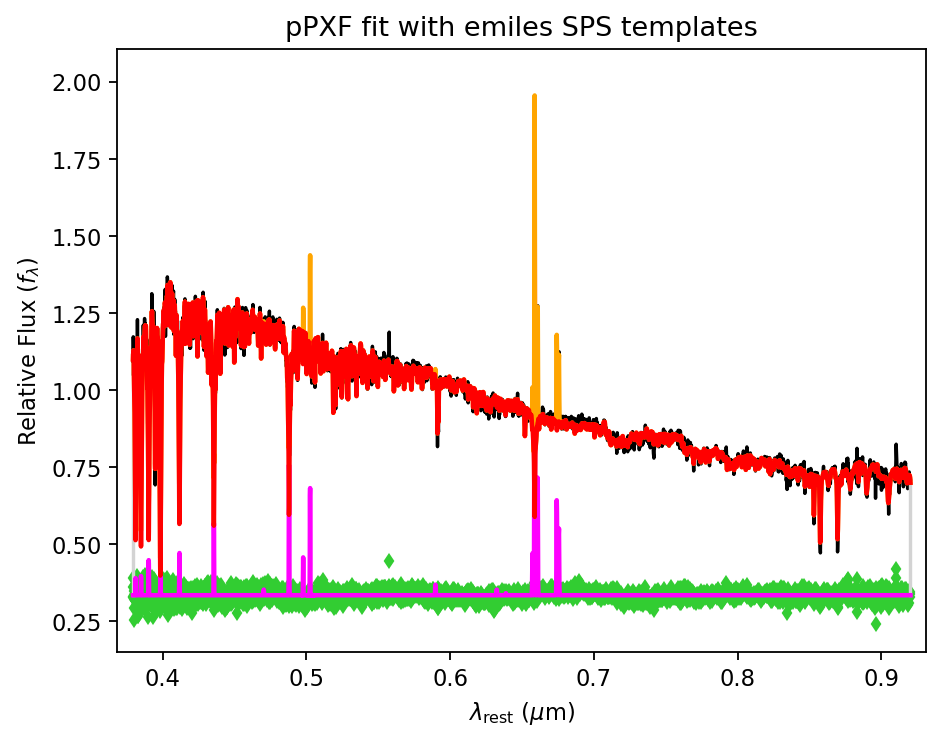

In [18]:
pp.plot()
plt.title(f"pPXF fit with {sps_name} SPS templates")
plt.pause(5)